# DL Potato Disease Detection Project


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf 
from tensorflow.keras import layers,models

In [2]:
Batch_Size=32
Image_Shape=256
Channels=3
epochs=50

## Lets build the tensorflow dataset taken for the plants disease classfication 

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "PlantVillage",
    seed=123,
    shuffle=True,
    batch_size=Batch_Size,
    image_size=(Image_Shape,Image_Shape)
)


Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch,image_label in dataset.take(1):
    print(image_batch.shape)
    print(image_label.numpy())

(32, 256, 256, 3)
[1 1 1 0 0 0 0 0 1 1 1 1 0 1 0 1 1 1 0 1 0 1 0 0 1 0 0 1 1 2 0 0]


## Lets see some of the images of the leaves 

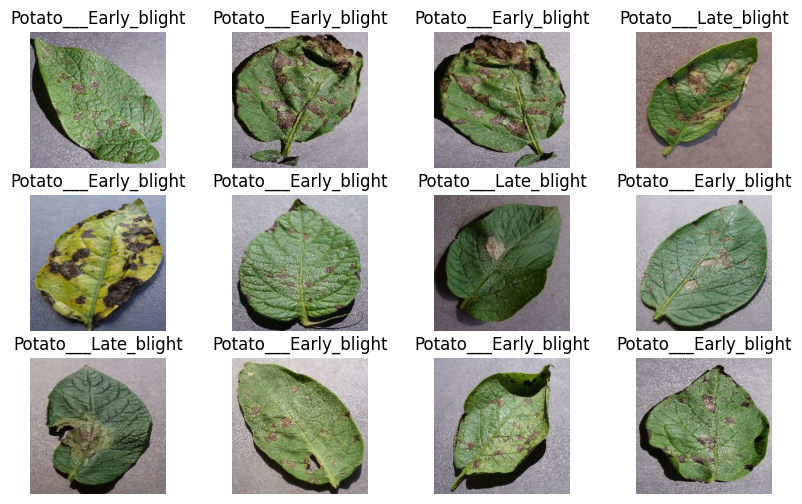

In [6]:
plt.figure(figsize=(10, 6))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Now lets divide our dataset into train, validation and testing parts 

In [7]:
len(dataset)

68

In [8]:
train_size=0.8
validation_size=0.1
test_size=0.1

In [9]:
train_ds=train_size*68
val_ds=validation_size*68
test_ds=test_size*68

In [10]:
train_ds

54.400000000000006

In [11]:
test_ds

6.800000000000001

In [12]:
val_ds

6.800000000000001

In [13]:
def dataset_partitions(ds,train_size=0.8,validation_size=0.1,test_size=0.1,shuffle=True,shuffle_size=1000):
    assert (train_size + test_size + validation_size) == 1
    
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=42)
    
    train_ds=ds.take(int(ds_size*train_size))
    test_ds=ds.skip(int(ds_size*train_size)).take(int(ds_size*test_size))
    val_ds=ds.skip(int(ds_size*train_size)).skip(int(ds_size*test_size))
    
    return train_ds,test_ds,val_ds


In [14]:
train_ds,test_ds,val_ds=dataset_partitions(dataset)

In [15]:
len(train_ds)

54

In [16]:
len(test_ds)

6

In [17]:
len(val_ds)

8

## Cache, Shuffle, and Prefetch the Dataset

In [18]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

# Building Model

### Data Resizing - For a image that will be used or the prediction and Scaling - used for scaling or normalizing the value of the pixels for any images

In [21]:
Resizing_and_Scaling=tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Shape,Image_Shape),
    layers.experimental.preprocessing.Rescaling(1./255)
])

### Data Augmentation -Increasing the size of your dataset in order to increase the generalization of the model

In [23]:
data_augmentation=tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

### Applying the Augmentation 

In [28]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building the model using the Convolutional Layers

In [32]:
input_shape=(Batch_Size,Image_Shape,Image_Shape,Channels)
n_classes=3

model=tf.keras.Sequential([
    Resizing_and_Scaling,
    layers.Conv2D(32,kernel_size=(3,3),activation="relu",input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation="relu"),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes,activation="softmax")

])

model.build(input_shape=input_shape)

In [33]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (32, 60, 60, 64)         

### lets Compile the Model

In [38]:
model.compile(
    optimizer="adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

### Lets train the model

In [39]:
model.fit(
    train_ds,
    batch_size=Batch_Size,
    validation_data=val_ds,
    verbose=1,
    epochs=5
    
)

Epoch 1/5
54/54 [==============================] - 526s 10s/step - loss: 0.8044 - accuracy: 0.5839 - val_loss: 0.8610 - val_accuracy: 0.6250
Epoch 2/5
54/54 [==============================] - 475s 9s/step - loss: 0.4942 - accuracy: 0.7946 - val_loss: 0.6334 - val_accuracy: 0.6758
Epoch 3/5
54/54 [==============================] - 488s 9s/step - loss: 0.3543 - accuracy: 0.8539 - val_loss: 0.3729 - val_accuracy: 0.8438
Epoch 4/5
54/54 [==============================] - 482s 9s/step - loss: 0.3001 - accuracy: 0.8803 - val_loss: 0.3020 - val_accuracy: 0.8828
Epoch 5/5
54/54 [==============================] - 512s 9s/step - loss: 0.2421 - accuracy: 0.9002 - val_loss: 0.2389 - val_accuracy: 0.9102


### Lets evaluate our model

In [40]:
model.evaluate(test_ds)

6/6 [==============================] - 20s 3s/step - loss: 0.2630 - accuracy: 0.8958


[0.26295724511146545, 0.8958333134651184]

### Plotting the Accuracy and Loss Curves

In [68]:
History=tf.keras.callbacks.History()

In [49]:
history

In [69]:
History.params

AttributeError: 'History' object has no attribute 'params'

In [51]:
history.history.keys()

dict_keys([])

In [54]:
acc=history.history["accuracy"]
loss=history.history["loss"]
val_acc=history.history["val_accuracy"]
val_loss=history.history["val_loss"]

KeyError: 'accuracy'

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(epochs),acc,color="r",label="accuracy")
plt.plot(range(epochs),val_acc,color="b",label="val_accuracy")
plt.title("Accuracy V/s Epochs")

plt.figure(figsize=(8,8))
plt.subplot(1,2,2)
plt.plot(range(epochs),loss,color="r",label="loss")
plt.plot(range(epochs),val_loss,color="b",label="val_loss")
plt.title("Loss V/s Epochs")

### Predictions Functions

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 3s 3s/step
predicted label: Potato___Early_blight


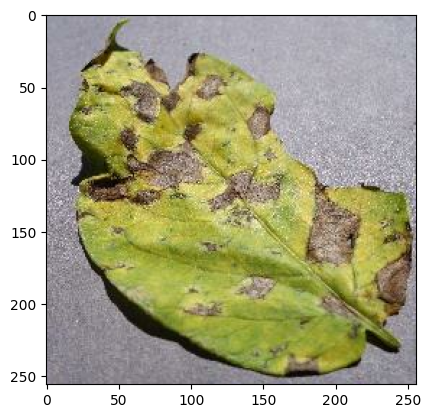

In [59]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [81]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    
   
    
    batch_prediction = model.predict(images_batch)
    print(batch_prediction[0])
    print(np.argmax(batch_prediction[0]))
          
    print(labels_batch.numpy())

1/1 [==============================] - 2s 2s/step
[9.8469663e-01 1.5303365e-02 3.9258065e-08]
0
[0 0 0 0 0 1 2 1 0 0 1 0 0 1 0 1 2 0 1 1 2 0 1 1 1 0 0 0 1 0 0 1]


### Write a function for inference

### Saving the Model

In [63]:
import os
model_version=max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1\assets


INFO:tensorflow:Assets written to: ../models/1\assets


In [64]:
model.save("../potatoes.h5")